<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/excercise_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Papers
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

# Exercises:
- E01: Tune the hyperparameters of the training to beat best validation loss of 2.2 (COMPLETE!)
  - Increase block_size
  - Increase size of Lookup table.
  - Increase hidden layer.
  - Length of the training
  - Learning rate
  - Batch size for convergence speed
- E02:
  - (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? --> Initialize the C matrix to ones, instead of random nums, and I would expect the loss to be 27! Because each char would be the same 1/27 out come. (COMPLETE! )
  - (2) Can you tune the initialization to get a starting loss that is much more similar to (1)? --> Initialize all parameters to 1. Loss is 3.2. Intution of 1 was wrong. Real reason of the Loss being 3.2 after having auniform distribution is that the last tensor is 200 streched out 27 times. Crossentropy: -log(1/27) = log(27) ~ 3.2.. (COMPLETE!)
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [1]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-22 01:31:54--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-06-22 01:31:54 (6.04 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}

In [5]:
# build the dataset
block_size = 4

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [36]:
g = torch.Generator().manual_seed(2147483647)
C = torch.ones((27, 20))
W1 = torch.ones((80, 200))
b1 = torch.ones(200)
W2 = torch.ones((200, 27))
b2 = torch.ones(27)
parameters = [C, W1, b1, W2, b2]

- Hidden layer size:
- 500 -> worse
- 300 -> worse
- 200 -> best so far
---
- Lookup table double -> dev set improve
---
- double the training length-> No improvement
---
- shorten train len to 10000, and increase batch size: 64 - no improvement.
- batch size: 128 - no improvement
- higher batch and longer training better
---
- increase block size improved perfromance on dev set.

In [37]:
sum(p.nelement() for p in parameters) # number of parameters in total

22167

In [38]:
for p in parameters:
  p.requires_grad = True

In [39]:
lri = []
lossi = []
stepi = []

In [40]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (128,))

  # forward pass
  emb = C[Xtr[ix]] # (128, 4, 20)
  h = torch.tanh(emb.view(-1, 80) @ W1 + b1) # (128, 200)
  logits = h @ W2 + b2 # (128, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  if i == 0:
    print(f'Initial loss: {loss}')
    break

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

Initial loss: 3.295837163925171
3.295837163925171


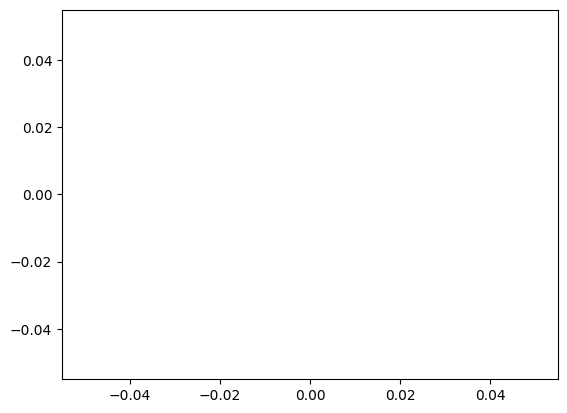

In [41]:
plt.plot(stepi, lossi)

In [13]:
def calculate_loss(X, Y):
  emb = C[X]
  h = torch.tanh(emb.view(-1, 80) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [22]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
train_loss

2.8309552669525146

In [23]:
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
dev_loss

2.828760862350464

In [ ]:
# test loss
test_loss = calculate_loss(Xte, Yte)
test_loss

2.1083648204803467

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
seelen.
hayla.
reiman.
endrie.
caileed.
eliiah.
poren.
edeineana.
arlely.
kohlara.
noshien.
gihiman.
trintoniel.
panter.
foun.
kynder.
yarley.
kaylah.
